In [193]:
import astro_ghost

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA





In [2]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         'feature_linear_trend_magn_r',
                         'feature_linear_trend_sigma_magn_r',
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         'feature_period_s_to_n_0_magn_r',
                         #'feature_period_1_magn_r', 
                         'feature_period_s_to_n_1_magn_r',
                         #'feature_period_2_magn_r', 
                         'feature_period_s_to_n_2_magn_r',
                         #'feature_period_3_magn_r', 
                         'feature_period_s_to_n_3_magn_r',
                         #'feature_period_4_magn_r', 
                         'feature_period_s_to_n_4_magn_r',
                         #'feature_periodogram_amplitude_magn_r',
                         'feature_periodogram_beyond_2_std_magn_r',
                         'feature_periodogram_beyond_3_std_magn_r',
                         'feature_periodogram_standard_deviation_magn_r', 
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         'feature_linear_trend_magn_g',
                         'feature_linear_trend_sigma_magn_g',
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         'feature_period_s_to_n_0_magn_g',
                         #'feature_period_1_magn_g', 
                         'feature_period_s_to_n_1_magn_g',
                         #'feature_period_2_magn_g', 
                         'feature_period_s_to_n_2_magn_g',
                         #'feature_period_3_magn_g', 
                         'feature_period_s_to_n_3_magn_g',
                         #'feature_period_4_magn_g', 
                         'feature_period_s_to_n_4_magn_g',
                         #'feature_periodogram_amplitude_magn_g',
                         'feature_periodogram_beyond_2_std_magn_g',
                         'feature_periodogram_beyond_3_std_magn_g',
                         'feature_periodogram_standard_deviation_magn_g', 
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']

In [3]:
dataset_bank = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,
                                  index_col='ztf_object_id')
        
# drop row if any feature values are nan
dataset_bank = dataset_bank[~dataset_bank[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7,125,129,130,131,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,anom_score,anomaly_score,anomaly_mask,anomaly_type,is_corrected,vpdf_extreme_version,vpdf_extreme_faint,vpdf_extreme_bright,locus_gal_l,locus_gal_b
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.881532,-69.513571
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.200342,-26.246909
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352953
ZTF17aaaskvj,59,ANT2018ftblk,28.015003,36.953216,"['lc_feature_extractor', 'high_snr']","['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1504,583,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352954
ZTF18aczbnhl,97,ANT2019dsk24,85.049145,-11.013302,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,105,12,ztf_candidate:718232301815010005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.961559,-20.751422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aberawv,999927,ANT2020aebbk,292.910293,54.078978,"['lc_feature_extractor', 'dimmers']",[],NaN,235,96,ztf_candidate:1231482062015010023,...,NaN,0.417276,Fail,TBD,NaN,NaN,NaN,NaN,85.961850,16.149525
ZTF18acrvsjf,999938,ANT2019zf6fg,72.820139,1.073984,['lc_feature_extractor'],"['allwise', 'bright_guide_star_cat', '2mass_ps...",NaN,40,14,ztf_candidate:696399341515010050,...,NaN,NaN,NaN,TBD,NaN,NaN,NaN,NaN,197.132900,-25.906137
ZTF18acdqrna,999957,ANT2020aefhrvi,53.476865,77.496741,['lc_feature_extractor'],"['allwise', 'bright_guide_star_cat', '2mass_ps...",NaN,83,36,ztf_candidate:1353408024115015003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.425108,17.392307


In [4]:
# only keep features of bank
dataset_bank_orig = dataset_bank[feature_names_r_g]
dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,feature_standard_deviation_magn_g,feature_stetson_k_magn_g,feature_weighted_mean_magn_g,feature_anderson_darling_normal_flux_g,feature_cusum_flux_g,feature_excess_variance_flux_g,feature_kurtosis_flux_g,feature_mean_variance_flux_g,feature_skew_flux_g,feature_stetson_k_flux_g
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,0.344664,0.833143,18.288298,-0.741267,0.244416,0.409971,-0.783581,-0.535533,-0.061333,0.815809
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,0.255341,0.796845,17.025929,0.013852,0.276394,0.369215,0.319612,-0.616276,0.720649,0.746565
ZTF17aaaskvj,1.325100,0.305955,0.310345,0.194759,0.069613,1.452066,0.900613,0.490911,1.562089,-0.000205,...,0.384571,0.542215,16.768612,1.073154,0.119285,0.611570,4.490889,-0.309191,2.390988,0.613781
ZTF17aaaskvj,1.325100,0.300439,0.308219,0.194091,0.072355,1.448558,0.899251,0.491846,1.551687,-0.000213,...,0.386585,0.541809,16.773018,1.066396,0.119160,0.611631,4.488470,-0.309169,2.386820,0.613769
ZTF18aczbnhl,0.276431,-0.610376,0.250000,0.000000,0.370062,0.552862,0.552862,0.316462,1.948112,-0.000285,...,0.492342,0.871093,18.629537,-0.228569,0.247441,0.547583,-1.541604,-0.365630,0.163018,0.879632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aberawv,0.300650,-0.429238,0.297297,0.232495,0.184334,0.595349,0.392779,0.242816,-0.351417,0.000136,...,0.155849,0.792311,19.806295,-0.593235,0.204807,-0.221537,-0.302184,-0.857277,-0.176622,0.787504
ZTF18acrvsjf,0.383450,-0.343338,0.166667,0.000000,0.422187,0.766899,0.732969,0.427601,-1.013720,0.013309,...,0.399852,0.863606,18.111818,-0.572841,0.379990,0.461553,-0.568062,-0.479605,-0.111461,0.810731
ZTF18acdqrna,0.371200,-0.664954,0.277778,0.000000,0.321254,0.742399,0.511758,0.323900,-0.753142,-0.001131,...,0.306282,0.747445,17.685317,-0.366746,0.267253,0.396504,1.539943,-0.555800,0.748662,0.795946


In [5]:

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


#scaler = preprocessing.StandardScaler() # Create a scalar
scaler = preprocessing.MinMaxScaler() # Create a scalar
#scaler = preprocessing.MaxAbsScaler() # Create a scalar
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

#print("scaler")
#scaler.fit(feat_arr) # Fit only to training data
#feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on
#print(np.shape(feat_arr_scaled))
#print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

#OR try scalar then PCA
print("pca")
# Initialize PCA with 15 principal components
n_components=25
pca = PCA(n_components=n_components)
feat_arr_scaled = scaler.fit_transform(feat_arr)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

pca
[0.23039056 0.39547268 0.49004163 0.56279701 0.60597478 0.64293407
 0.6744957  0.70133184 0.72597255 0.74994114 0.7706908  0.79061063
 0.80817714 0.8234333  0.83753344 0.85101642 0.86316356 0.87477586
 0.88583139 0.89628417 0.9060682  0.91311195 0.91992921 0.92576442
 0.93115947]


# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [6]:
# Scalar then PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.538141,0.148851,-0.438363,-0.093599,-0.261809,0.485150,0.035723,0.123459,0.049304,-0.180760,...,-0.061741,-0.099706,0.088888,0.110417,0.061632,-0.140906,-0.149454,0.053278,-0.050590,-0.020417
ZTF18acfvwwa,0.599408,0.223573,0.076394,0.240885,0.136615,0.360182,-0.023249,0.034717,-0.120691,-0.186074,...,-0.000541,-0.105709,0.111936,0.069446,0.045642,0.069960,-0.078071,-0.073879,0.122081,-0.019856
ZTF17aaaskvj,1.218188,0.855351,0.249786,0.255937,-0.267852,-0.225082,0.387865,0.401781,0.148523,0.136416,...,-0.105649,0.230644,-0.045422,-0.057812,-0.052772,-0.080976,0.008907,0.094828,0.257803,0.074800
ZTF17aaaskvj,1.200853,0.852557,0.249214,0.251377,-0.274088,-0.224367,0.391013,0.396215,0.156524,0.115361,...,-0.099176,0.219160,-0.045760,-0.057039,-0.046076,-0.089004,0.019541,0.099144,0.259824,0.077782
ZTF18aczbnhl,-0.348307,-0.194542,-0.443213,0.187053,-0.214084,-0.373077,-0.388558,0.205781,-0.165907,-0.141434,...,0.156824,-0.130717,-0.163214,0.147218,-0.053458,0.110482,0.096973,-0.077913,0.344238,-0.142102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aberawv,0.930267,-0.456519,0.027062,0.396545,-0.143151,0.076985,0.033647,-0.058114,-0.045080,-0.005292,...,-0.171806,-0.062068,0.010930,-0.082148,-0.004437,0.036721,-0.001366,-0.092776,0.009555,0.033160
ZTF18acrvsjf,-0.731951,-0.304998,0.282716,0.094136,0.210098,0.207501,0.139914,-0.186067,0.060418,-0.152371,...,-0.154253,0.145256,-0.054041,0.158486,-0.245874,-0.186320,-0.017635,0.027911,-0.157447,-0.087322
ZTF18acdqrna,0.262027,0.080751,0.666251,0.078619,0.027661,0.234308,-0.247695,-0.080371,-0.048387,-0.075489,...,0.047797,-0.046788,-0.075095,0.038725,-0.154467,0.000432,-0.144395,-0.137729,0.024415,0.030596


In [7]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()


dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia (lower first ANN dist), 0.3478 [eucl.], 2.1561 [manhattan], 21.8293 [dot], 0 for first 3, then 1,2... [hamming], 0.077 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, , 4.449 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), 0.7893, 4.5839 [manhattan], 21.5625 [dot], 8! for first one, then 9,10... [hamming], 0.1678 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf
dataset_ref 

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aassamj,-0.587521,0.070572,-0.126513,0.394259,0.943086,-0.21293,-0.178959,0.210465,0.176929,0.062475,...,-0.125544,-0.065491,0.023162,-0.075895,-0.003522,-0.107265,-0.13871,0.116586,-0.10981,-0.118314


In [8]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# Scalar then PCA
scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = display_markdown(f'https://alerce.online/object/{ztf_id}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

ZTF ID name (ref) ZTF21aassamj


https://alerce.online/object/ZTF21aassamj

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF21aassamj

0		90181				None			0.0


https://alerce.online/object/ZTF20acwnrty

1		17019				None			0.2339


https://alerce.online/object/ZTF20acnvlgg

2		5478				None			0.2872


https://alerce.online/object/ZTF21aanwfjk

3		46111				None			0.3016


https://alerce.online/object/ZTF21aaswvyc

4		15214				None			0.3209


https://alerce.online/object/ZTF18acybdar

5		4456				None			0.3412


https://alerce.online/object/ZTF21aavqwhh

6		82995				None			0.3437


https://alerce.online/object/ZTF21aawzsew

7		70057				None			0.3461


https://alerce.online/object/ZTF21abjeyoh

8		62841				None			0.364


https://alerce.online/object/ZTF21aapkvrd

9		8026				None			0.3879


In [9]:
results_df = dataset_bank[dataset_bank.index.isin(idx_arr[result_id])]
results_df = results_df.reindex(idx_arr[result_id])
results_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aassamj,-0.587521,0.070572,-0.126513,0.394259,0.943086,-0.212930,-0.178959,0.210465,0.176929,0.062475,...,-0.125544,-0.065491,0.023162,-0.075895,-0.003522,-0.107265,-0.138710,0.116586,-0.109810,-0.118314
ZTF20acwnrty,-0.570213,0.034169,-0.065447,0.401728,0.934496,-0.195782,-0.091707,0.226873,0.166903,0.073626,...,-0.067060,-0.115091,0.005582,-0.009201,-0.047786,-0.123200,-0.115964,0.083710,-0.096265,0.019538
ZTF20acnvlgg,-0.589578,0.112118,-0.134781,0.467056,1.039584,-0.111479,-0.150210,0.232211,0.263105,0.044815,...,-0.106355,-0.033343,-0.031127,-0.086110,-0.011866,-0.039453,-0.026757,0.075698,-0.157482,-0.079921
ZTF21aanwfjk,-0.597311,-0.019940,-0.180887,0.303186,0.896591,-0.190956,-0.093992,0.159115,0.242351,0.021442,...,-0.148382,-0.066381,0.000180,0.039943,0.057662,-0.080680,-0.114610,0.144294,-0.137161,-0.065118
ZTF21aaswvyc,-0.676021,-0.087664,-0.021890,0.445203,0.906650,-0.232044,-0.078571,0.130160,0.138213,0.068095,...,-0.052797,-0.042542,0.042463,-0.039908,0.008036,-0.075868,-0.152628,0.132114,-0.032558,-0.022682
ZTF18acybdar,-0.549718,0.042921,-0.202282,0.430677,0.896244,-0.110288,-0.137779,0.208039,0.209296,0.053679,...,-0.057658,-0.023276,-0.055530,-0.041618,-0.049878,0.025804,-0.176749,0.075036,-0.027130,-0.199218
ZTF21aavqwhh,-0.613919,-0.113277,-0.055076,0.327895,0.904119,-0.112637,-0.115731,0.181163,0.270483,0.051429,...,-0.041757,-0.051719,0.063423,-0.071583,0.065967,-0.030456,-0.111697,0.069765,-0.083211,-0.049772
ZTF21aawzsew,-0.725151,0.042928,-0.192530,0.517175,0.974893,-0.103694,-0.156921,0.282620,0.160099,-0.030958,...,-0.099074,0.039474,0.054926,0.017550,0.080260,-0.040470,-0.159244,0.096470,-0.050289,-0.157567
ZTF21abjeyoh,-0.658946,0.083789,-0.241590,0.437300,0.944343,-0.219907,-0.120674,0.251285,0.169135,-0.039792,...,-0.082187,-0.082120,-0.026031,-0.015639,-0.052800,0.057746,-0.021844,0.187007,-0.004168,-0.087231


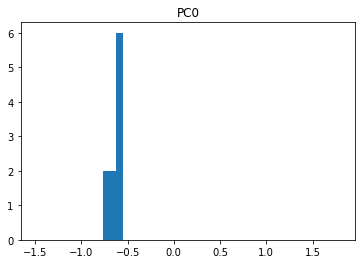

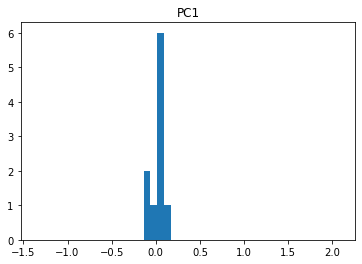

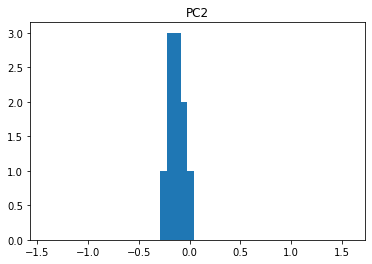

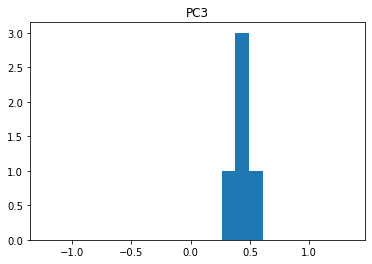

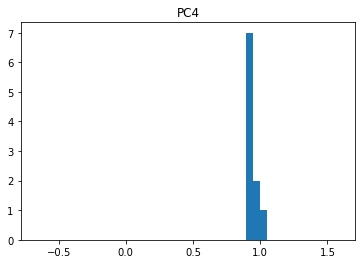

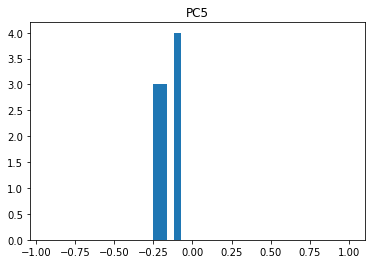

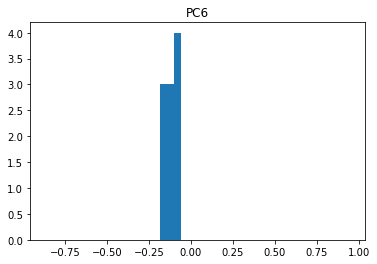

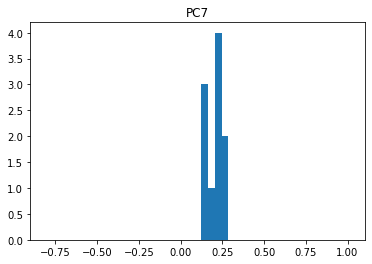

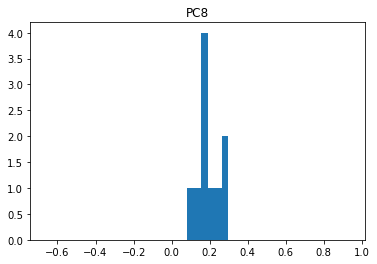

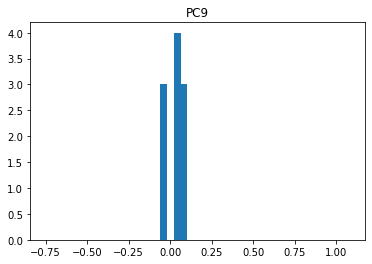

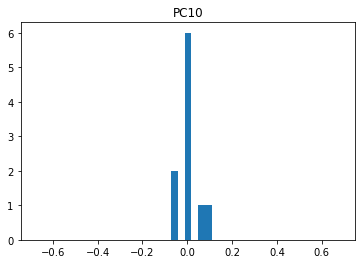

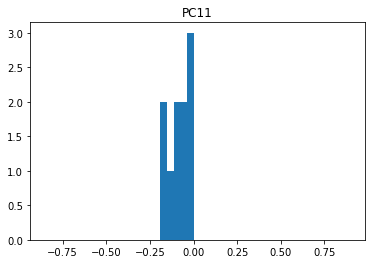

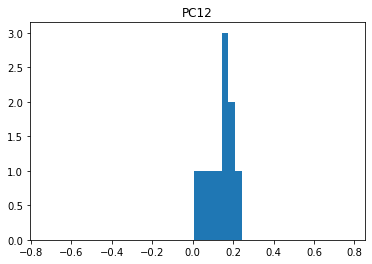

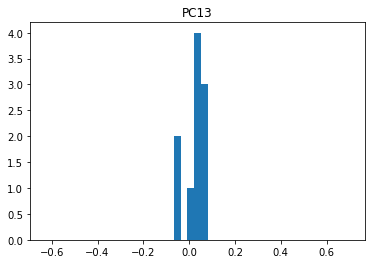

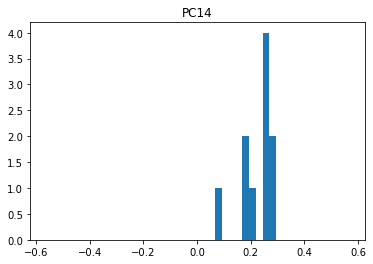

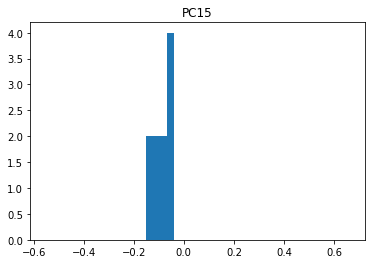

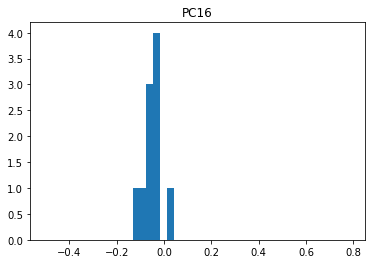

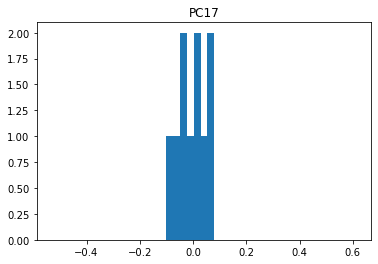

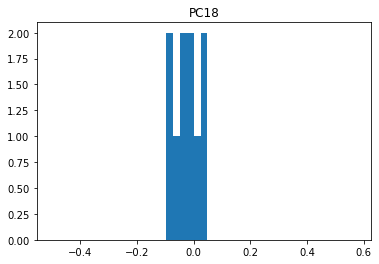

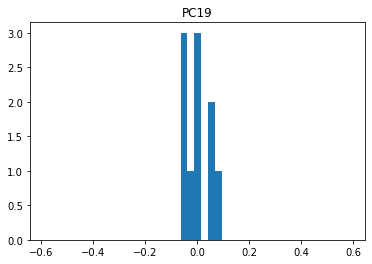

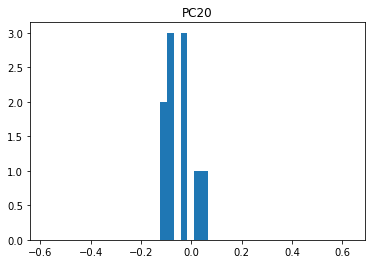

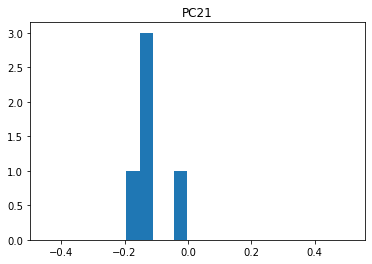

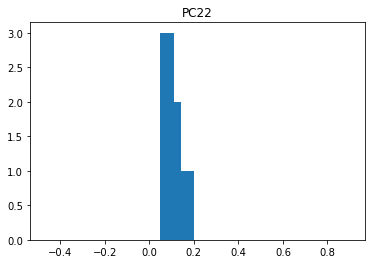

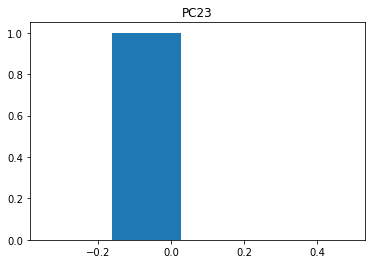

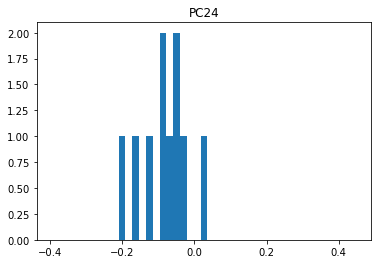

In [10]:
feat_scatter_l = []
for feat in results_df.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(results_df[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(results_df[feat])
    feat_scatter_l.append(feat_scatter)    

In [11]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 0.05074030092914212
Scatter median: 0.049975244222419446
Scatter std: 0.01086311232852437
Scatter max: 0.07502083783490031
Scatter min: 0.03189186960037152


In [82]:
list(np.unique(dataset_bank.index))

['ZTF17aaaacoy',
 'ZTF17aaaacsm',
 'ZTF17aaaadml',
 'ZTF17aaaaemx',
 'ZTF17aaaaene',
 'ZTF17aaaaenu',
 'ZTF17aaaaess',
 'ZTF17aaaaewv',
 'ZTF17aaaankp',
 'ZTF17aaaaxzi',
 'ZTF17aaaayua',
 'ZTF17aaaayzx',
 'ZTF17aaaazhi',
 'ZTF17aaaazkn',
 'ZTF17aaaazmz',
 'ZTF17aaabgbh',
 'ZTF17aaabgbm',
 'ZTF17aaabgby',
 'ZTF17aaabgdz',
 'ZTF17aaabgep',
 'ZTF17aaabghb',
 'ZTF17aaabgil',
 'ZTF17aaabgpy',
 'ZTF17aaabgsl',
 'ZTF17aaabmmo',
 'ZTF17aaabuab',
 'ZTF17aaaccjr',
 'ZTF17aaaccnn',
 'ZTF17aaaceht',
 'ZTF17aaaceyf',
 'ZTF17aaaczhj',
 'ZTF17aaadars',
 'ZTF17aaadasl',
 'ZTF17aaadlcq',
 'ZTF17aaadlhe',
 'ZTF17aaadndc',
 'ZTF17aaadoqi',
 'ZTF17aaadozl',
 'ZTF17aaadpdd',
 'ZTF17aaadpkb',
 'ZTF17aaadpkl',
 'ZTF17aaadpkz',
 'ZTF17aaadqae',
 'ZTF17aaadqdy',
 'ZTF17aaadqyf',
 'ZTF17aaadrbc',
 'ZTF17aaadroa',
 'ZTF17aaadrrq',
 'ZTF17aaaduyi',
 'ZTF17aaaduzw',
 'ZTF17aaadvan',
 'ZTF17aaadvbj',
 'ZTF17aaadvbq',
 'ZTF17aaadvfh',
 'ZTF17aaadvfi',
 'ZTF17aaadvmt',
 'ZTF17aaaegxm',
 'ZTF17aaaehfq',
 'ZTF17aaaehps

In [177]:
%%time

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank.index))[0:10000]:
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')

# find average (mean) distance of first 9 ANNs.
col_list= [f'dist={col}' for col in range(1, 10)]
# sum specific columns
ann_dist_all_df[f'Mean_{len(col_list)}ANNs'] = (ann_dist_all_df[col_list].sum(axis=1))/(len(col_list))

# weighted distance of first 9 ANNs
weight_l = [34, 21, 13, 8, 5, 3, 2, 1, 1] # Fibonacci seq.
ann_dist_all_df[f'WeightedMean_{len(col_list)}ANNs'] = np.average(ann_dist_all_df[col_list], weights=weight_l, axis=1)
ann_dist_all_df

CPU times: user 1min 11s, sys: 333 ms, total: 1min 11s
Wall time: 1min 11s


,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9,Mean_9ANNs,WeightedMean_9ANNs
key_0,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaacoy,86647,31494,44394,51539,18892,45597,36962,46621,56870,76025,...,0.427520,0.441686,0.499101,0.528973,0.564232,0.580511,0.582243,0.593148,0.513995,0.446330
ZTF17aaaacsm,6582,66800,37005,39025,70683,1379,16463,19048,89308,69265,...,0.482770,0.492930,0.523796,0.528795,0.529938,0.530892,0.542349,0.544470,0.514988,0.485493
ZTF17aaaadml,42918,76851,36232,27666,79407,32548,61038,65928,75879,45484,...,0.514876,0.520238,0.521422,0.521685,0.522198,0.550329,0.555622,0.576350,0.532069,0.515401
ZTF17aaaaemx,74875,60172,67314,27617,82926,40235,89847,74572,6329,25457,...,0.422978,0.443602,0.459196,0.460676,0.460821,0.467661,0.468161,0.471162,0.445193,0.407587
ZTF17aaaaene,64679,49491,41985,67406,41400,70317,78067,34202,42598,72274,...,0.443556,0.448340,0.449720,0.451494,0.453022,0.456409,0.456645,0.460210,0.449616,0.439886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18abcjjoz,54661,62192,26384,76422,37782,14154,47743,42877,69306,74870,...,0.523861,0.566138,0.569343,0.621141,0.632366,0.633917,0.634952,0.636624,0.593062,0.546718
ZTF18abcjjwe,71534,24562,87701,77897,45741,14166,5093,43902,53628,1294,...,0.640987,0.649310,0.661624,0.707190,0.711042,0.714804,0.728780,0.731650,0.670665,0.595842
ZTF18abcjlhs,40334,3210,2973,1656,76812,79214,88536,68443,75506,34733,...,0.515947,0.521909,0.529006,0.561579,0.568707,0.569207,0.571795,0.577382,0.545310,0.515798


In [178]:
# Pick distance metric. 
# Weighted mean of first 9 ANNs (Fibonacci), OR Mean of first 9 ANNs, OR distance to first ANN. 
# TODO: EXPLORE DIFFERENT METRICS!
dist_col = f'WeightedMean_{len(col_list)}ANNs'  # f'Mean_{len(col_list)}ANNs' # 'dist=1'

print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of mean distance of 9 ANNs
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.5417224160828206
Scatter median: 0.5388960994102738
Scatter std: 0.09927460268772428
Scatter max: 1.4100519093600186
Scatter min: 0.17514450822702862


Most anomalous: ZTF18abcfcoo


# Largest distance

In [179]:
ref_obj = ann_dist_all_df[[dist_col]].idxmax().values[0] #'ZTF18acbwaxk'
print("Max dist", ann_dist_all_df.loc[ref_obj][dist_col]) 

Max dist 1.4100519093600186


In [180]:
dataset_bank[dataset_bank.index == ref_obj]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abcfcoo,0.606933,1.018831,1.120599,-0.31076,0.468529,-0.841392,0.042706,-0.357962,0.412538,0.326444,...,-0.465859,0.362053,-0.248571,0.064425,0.533324,0.400111,-0.09366,0.064697,0.092615,0.172554


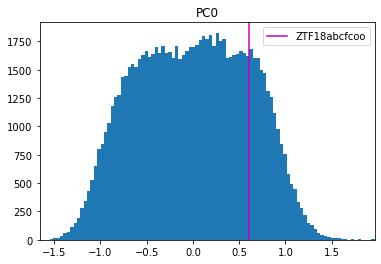

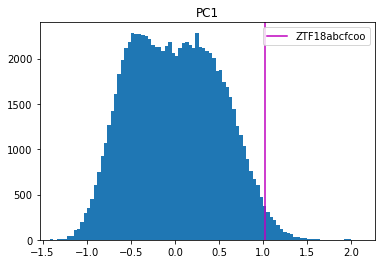

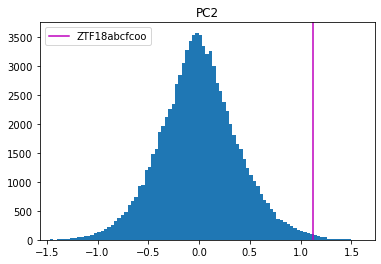

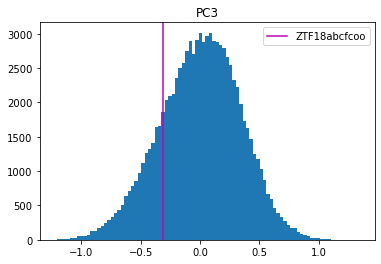

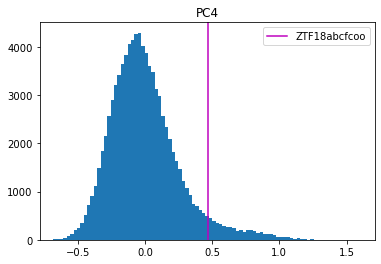

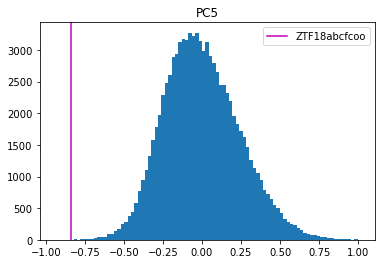

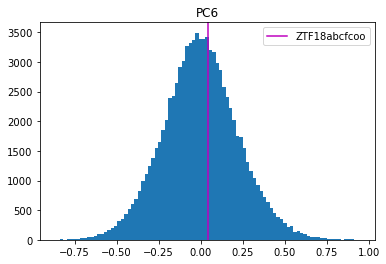

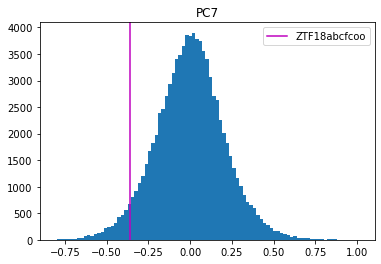

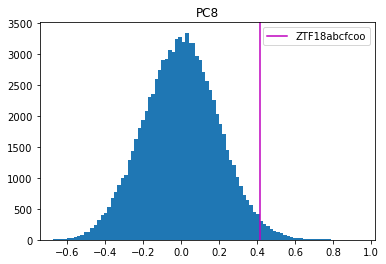

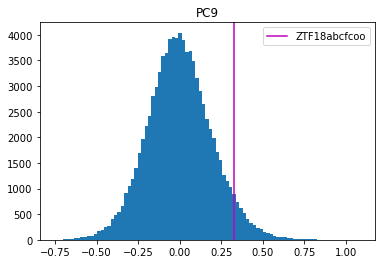

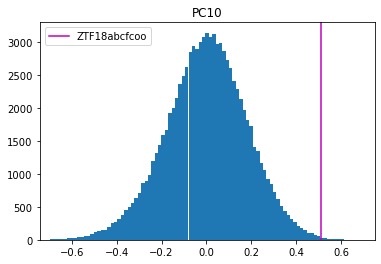

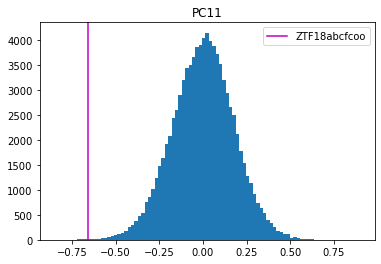

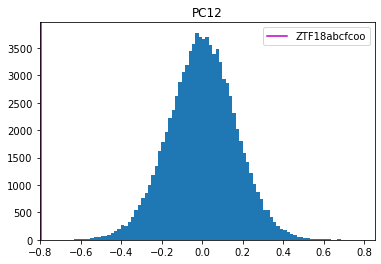

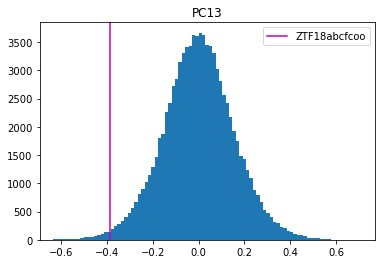

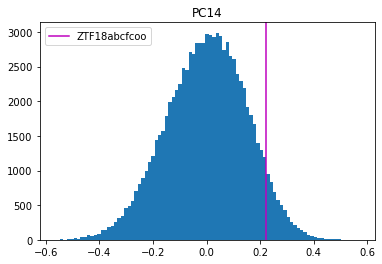

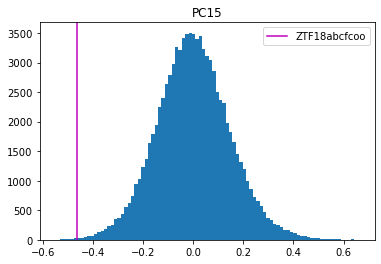

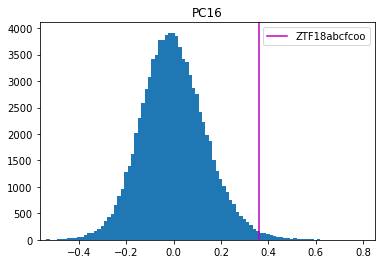

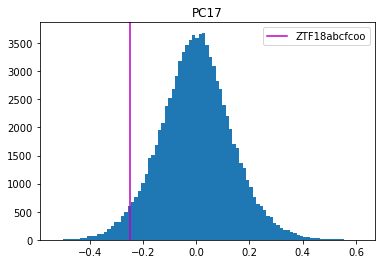

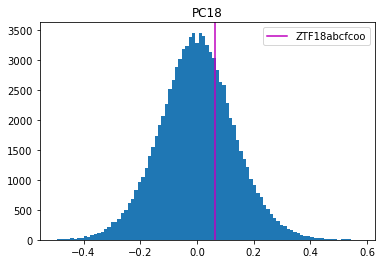

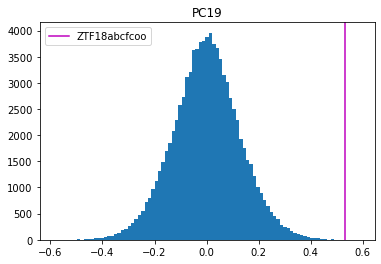

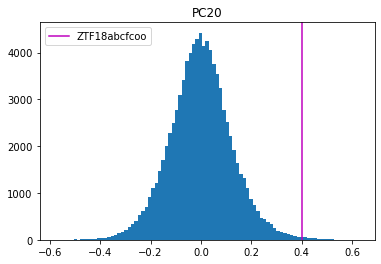

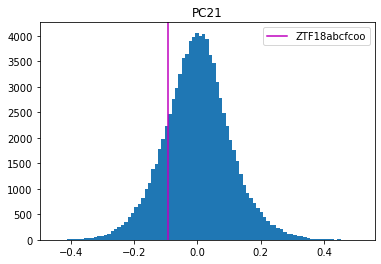

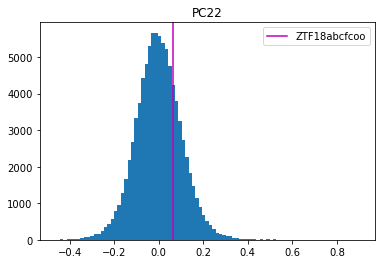

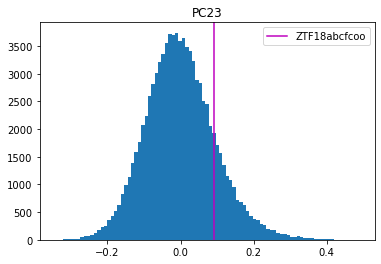

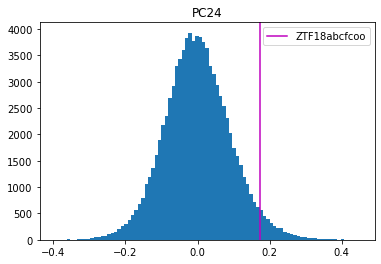

In [181]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [189]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj] #  ref_obj

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[0.6069325751554592 1.0188306697006937 1.120598546678515
 -0.31076037714091675 0.46852900196956554 -0.8413921283038358
 0.042705809535899586 -0.35796158839284586 0.41253834386348487
 0.3264444053599188 0.5090310069008187 -0.6564600545260704
 -0.7975784097049513 -0.38598762245263174 0.2205260603274108
 -0.4658588352252766 0.36205265612792936 -0.2485708765983756
 0.06442528125942203 0.533324241023802 0.4001112176276529
 -0.0936599359893522 0.06469744635667238 0.09261543578207962
 0.172554323649387]
ZTF ID name (ref) ZTF18abcfcoo


https://alerce.online/object/ZTF18abcfcoo

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF18abcfcoo

0		68288				None			0.0


https://alerce.online/object/ZTF18abdcpmd

1		40715				None			1.3136


https://alerce.online/object/ZTF18aaniglz

2		54430				None			1.4458


https://alerce.online/object/ZTF19abotnhf

3		33764				None			1.457


https://alerce.online/object/ZTF18aarjqda

4		74949				None			1.4621


https://alerce.online/object/ZTF18abnjsqz

5		76935				None			1.5166


https://alerce.online/object/ZTF18aaufckh

6		48682				None			1.5257


https://alerce.online/object/ZTF18abhzofh

7		72548				None			1.563


https://alerce.online/object/ZTF20acwrpxr

8		73016				None			1.5681


https://alerce.online/object/ZTF18abeqqzu

9		76620				None			1.5696


In [183]:
ann_dist_all_df.loc[ref_obj]

ann=0                 68288.000000
ann=1                 40715.000000
ann=2                 54430.000000
ann=3                 33764.000000
ann=4                 74949.000000
ann=5                 76935.000000
ann=6                 48682.000000
ann=7                 72548.000000
ann=8                 73016.000000
ann=9                 76620.000000
dist=0                    0.000000
dist=1                    1.313559
dist=2                    1.445812
dist=3                    1.456996
dist=4                    1.462139
dist=5                    1.516577
dist=6                    1.525657
dist=7                    1.562958
dist=8                    1.568068
dist=9                    1.569595
Mean_9ANNs                1.491262
WeightedMean_9ANNs        1.410052
Name: ZTF18abcfcoo, dtype: float64

In [184]:
# 10 largest distances
ann_dist_all_df[dist_col].nlargest(100)

key_0
ZTF18abcfcoo    1.410052
ZTF18aaslagi    1.260550
ZTF18aarwyww    1.128370
ZTF18aabrxof    1.116732
ZTF18abaphqf    1.088122
                  ...   
ZTF18aaachlc    0.798663
ZTF18aabhkro    0.797845
ZTF18abbhiqo    0.796803
ZTF18aamycpv    0.796395
ZTF18abcjfjq    0.796083
Name: WeightedMean_9ANNs, Length: 100, dtype: float64

In [188]:
# 10 largest distances objs 
for ztfid in list(ann_dist_all_df[dist_col].nlargest(100).index):
    alerce_link = display_markdown(f'https://alerce.online/object/{ztfid}', raw=True)
    print(alerce_link)

https://alerce.online/object/ZTF18abcfcoo

None


https://alerce.online/object/ZTF18aaslagi

None


https://alerce.online/object/ZTF18aarwyww

None


https://alerce.online/object/ZTF18aabrxof

None


https://alerce.online/object/ZTF18abaphqf

None


https://alerce.online/object/ZTF18aaoscbs

None


https://alerce.online/object/ZTF18aabjkap

None


https://alerce.online/object/ZTF18aanoyin

None


https://alerce.online/object/ZTF18aaxuusk

None


https://alerce.online/object/ZTF18aabfadv

None


https://alerce.online/object/ZTF18abbuguo

None


https://alerce.online/object/ZTF18aavskan

None


https://alerce.online/object/ZTF18aamnlze

None


https://alerce.online/object/ZTF18aaarzgv

None


https://alerce.online/object/ZTF17aabowel

None


https://alerce.online/object/ZTF18abaebfk

None


https://alerce.online/object/ZTF18abaeawz

None


https://alerce.online/object/ZTF18aabtugl

None


https://alerce.online/object/ZTF17aaazrnw

None


https://alerce.online/object/ZTF18aabgpcg

None


https://alerce.online/object/ZTF18aajcnnr

None


https://alerce.online/object/ZTF18aaoritn

None


https://alerce.online/object/ZTF18abbcdhn

None


https://alerce.online/object/ZTF17aacufux

None


https://alerce.online/object/ZTF18aasuwtt

None


https://alerce.online/object/ZTF18aamvgmq

None


https://alerce.online/object/ZTF18aabeyaq

None


https://alerce.online/object/ZTF18aaqbjuo

None


https://alerce.online/object/ZTF18abcgrvs

None


https://alerce.online/object/ZTF18abcjfhf

None


https://alerce.online/object/ZTF18aaakiea

None


https://alerce.online/object/ZTF18aapnjqb

None


https://alerce.online/object/ZTF18aazflnx

None


https://alerce.online/object/ZTF18aajqcue

None


https://alerce.online/object/ZTF17aaawelz

None


https://alerce.online/object/ZTF18abccmnl

None


https://alerce.online/object/ZTF18abbvabu

None


https://alerce.online/object/ZTF18abbfwzv

None


https://alerce.online/object/ZTF18aaabjgd

None


https://alerce.online/object/ZTF18aakuood

None


https://alerce.online/object/ZTF18aaahuqh

None


https://alerce.online/object/ZTF18aaqcuba

None


https://alerce.online/object/ZTF18aaorymm

None


https://alerce.online/object/ZTF17aaahmid

None


https://alerce.online/object/ZTF18aanwveg

None


https://alerce.online/object/ZTF18aabhmmj

None


https://alerce.online/object/ZTF18abccckv

None


https://alerce.online/object/ZTF18aajtyio

None


https://alerce.online/object/ZTF18aakfnru

None


https://alerce.online/object/ZTF18aarsokt

None


https://alerce.online/object/ZTF18aaimlad

None


https://alerce.online/object/ZTF18aabjlqa

None


https://alerce.online/object/ZTF17aabdfvr

None


https://alerce.online/object/ZTF18aaeduxh

None


https://alerce.online/object/ZTF17aabwwfn

None


https://alerce.online/object/ZTF18aamynjn

None


https://alerce.online/object/ZTF18abazbzi

None


https://alerce.online/object/ZTF18aahheaj

None


https://alerce.online/object/ZTF17aabhioj

None


https://alerce.online/object/ZTF18aairvdw

None


https://alerce.online/object/ZTF18abbrbzw

None


https://alerce.online/object/ZTF18aatzloy

None


https://alerce.online/object/ZTF18abbeynz

None


https://alerce.online/object/ZTF18aamtznx

None


https://alerce.online/object/ZTF18aapelal

None


https://alerce.online/object/ZTF18aaxlalb

None


https://alerce.online/object/ZTF18abbdfpf

None


https://alerce.online/object/ZTF18aanhiop

None


https://alerce.online/object/ZTF17aaatzdj

None


https://alerce.online/object/ZTF18aabukgo

None


https://alerce.online/object/ZTF18abccneq

None


https://alerce.online/object/ZTF18aarjsot

None


https://alerce.online/object/ZTF18abayusp

None


https://alerce.online/object/ZTF18aaqvdhr

None


https://alerce.online/object/ZTF18aaappvn

None


https://alerce.online/object/ZTF18aabibdk

None


https://alerce.online/object/ZTF17aabulcu

None


https://alerce.online/object/ZTF18aatxtlm

None


https://alerce.online/object/ZTF18aamxznr

None


https://alerce.online/object/ZTF18aaotqou

None


https://alerce.online/object/ZTF18aanuvrz

None


https://alerce.online/object/ZTF18aawlezq

None


https://alerce.online/object/ZTF18aaxlaxv

None


https://alerce.online/object/ZTF18aarwlyx

None


https://alerce.online/object/ZTF18aayfoyq

None


https://alerce.online/object/ZTF18aamxcmz

None


https://alerce.online/object/ZTF17aabaszq

None


https://alerce.online/object/ZTF18aajsuwc

None


https://alerce.online/object/ZTF18aavckhz

None


https://alerce.online/object/ZTF17aaafvrg

None


https://alerce.online/object/ZTF18aarjsfh

None


https://alerce.online/object/ZTF17aadmzyr

None


https://alerce.online/object/ZTF17aaafgly

None


https://alerce.online/object/ZTF18aaztwws

None


https://alerce.online/object/ZTF18aainzhi

None


https://alerce.online/object/ZTF18aaachlc

None


https://alerce.online/object/ZTF18aabhkro

None


https://alerce.online/object/ZTF18abbhiqo

None


https://alerce.online/object/ZTF18aamycpv

None


https://alerce.online/object/ZTF18abcjfjq

None


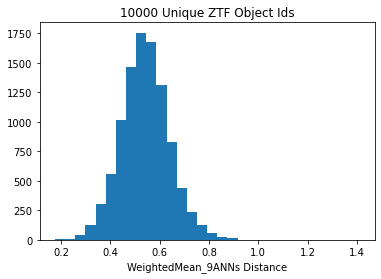

In [186]:
# 10 largest mean 9 ANN distances distances (most different)
plt.hist(ann_dist_all_df[dist_col], 
         bins=np.linspace(np.min(ann_dist_all_df[dist_col]), 
                          np.max(ann_dist_all_df[dist_col]), 31), density=False);
plt.xlabel(dist_col+' Distance');
#plt.yscale('log')
plt.title(f'{len(ann_dist_all_df)} Unique ZTF Object Ids');

In [187]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of distance
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.5417224160828206
Scatter median: 0.5388960994102738
Scatter std: 0.09927460268772428
Scatter max: 1.4100519093600186
Scatter min: 0.17514450822702862


Most anomalous: ZTF18abcfcoo


# Smallest

In [168]:
ann_dist_all_df[dist_col].nsmallest(10)

key_0
ZTF18aajbkjd    0.255398
ZTF20acaicfc    0.272783
ZTF18abxezzd    0.275732
ZTF18aaxuyls    0.282576
ZTF21aaabasz    0.283287
ZTF21aawgwmr    0.284263
ZTF17aaawell    0.286641
ZTF17aaawfrs    0.289914
ZTF18aaabcdb    0.293375
ZTF18aaabbiy    0.293789
Name: Mean_9ANNs, dtype: float64

In [170]:
# 10 smallest  distances (most similar)
for ztfid in list(ann_dist_all_df[dist_col].nsmallest(10).index):
    alerce_link = display_markdown(f'https://alerce.online/object/{ztfid}', raw=True)
    print(alerce_link)

https://alerce.online/object/ZTF18aajbkjd

None


https://alerce.online/object/ZTF20acaicfc

None


https://alerce.online/object/ZTF18abxezzd

None


https://alerce.online/object/ZTF18aaxuyls

None


https://alerce.online/object/ZTF21aaabasz

None


https://alerce.online/object/ZTF21aawgwmr

None


https://alerce.online/object/ZTF17aaawell

None


https://alerce.online/object/ZTF17aaawfrs

None


https://alerce.online/object/ZTF18aaabcdb

None


https://alerce.online/object/ZTF18aaabbiy

None


In [172]:
dataset_ref = dataset_bank[dataset_bank.index == list(ann_dist_all_df[dist_col].nsmallest(10).index)[0]]

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[1.1118625672404274 0.12331166271588095 0.10570747358964822
 0.6402489946117335 -0.3555800032511217 -0.16107825063069509
 0.15185003703067132 0.043900058528993265 0.16590757193213537
 0.061716284520621736 -0.06970753364443993 -0.1451497199683248
 0.09723107688392761 -0.024367541835719892 0.05910217065850591
 -0.041157975540847005 0.021209639718001393 0.0353191877766076
 -0.0290879850304357 -0.08542805521397168 -0.030455518360769894
 0.09514606675270045 -0.010053459752590765 0.08068756155415371
 0.04559110398794003]
ZTF ID name (ref) ZTF18aajbkjd


https://alerce.online/object/ZTF18aajbkjd

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF18aajbkjd

0		9673				None			0.0


https://alerce.online/object/ZTF18aajbkjd

1		56487				None			0.0352


https://alerce.online/object/ZTF18aaxuyls

2		2220				None			0.2419


https://alerce.online/object/ZTF18aavqrxt

3		2423				None			0.2599


https://alerce.online/object/ZTF17aaawfrs

4		42025				None			0.2799


https://alerce.online/object/ZTF18abedbto

5		72638				None			0.2883


https://alerce.online/object/ZTF18abedbto

6		89221				None			0.2932


https://alerce.online/object/ZTF18aaiojpk

7		34187				None			0.2976


https://alerce.online/object/ZTF18aaoebtu

8		49198				None			0.3008


https://alerce.online/object/ZTF18aaxuyew

9		54959				None			0.3019


In [173]:
# dist ANN=1 and mean of first 9 ANN are roughly same (SN, CV, Mira, etc). 
# Not as many SN (but otherwise similar as above) in weighted (fibonacci) average of first 9 ANN.
# Separation will come down to host gal info

MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787